In [57]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

from collections import defaultdict

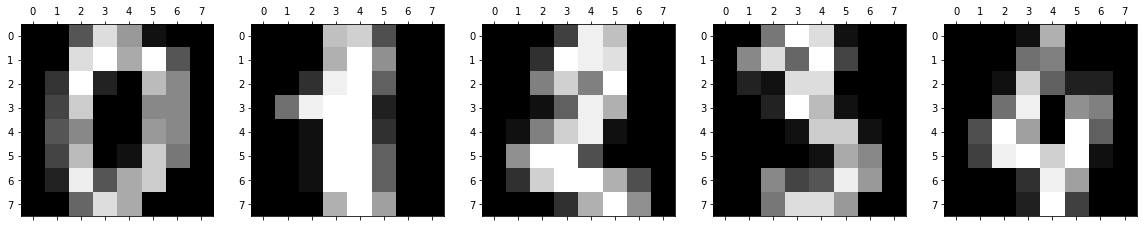

In [10]:
X, y = load_digits(return_X_y=True)
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharex=True,)
plt.gray()
for i, axis in enumerate(axes):
    axis.matshow(X[i, :].reshape(8, 8))
plt.show()

In [112]:
class CNN(torch.nn.Module):
    def __init__(self, linear_layer_size):
        super(CNN, self).__init__()
        self.linear_layer_size = linear_layer_size

        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=2)
        self.conv2 = torch.nn.Conv2d(32, 16, kernel_size=2)
        self.linear = torch.nn.Linear(linear_layer_size, 10)

    def forward(self, x):
        batch_size = x.size(0)

        relu = torch.nn.ReLU()
        maxpool = torch.nn.MaxPool2d(kernel_size=2)

        x = self.conv1(x)
        x = maxpool(relu(x))

        x = self.conv2(x)
        x = maxpool(relu(x))

        x = x.reshape(batch_size, self.linear_layer_size)
        x = self.linear(x)
        return x

In [62]:
def print_model(model):
    """ 
    A simple functon that prints out a PyTorch model's structural details
    """
    # Print the number of parameters in the model
    parameter_count =  sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("In total, this network has ", parameter_count, " parameters")

In [15]:
def run_one_epoch(model, optimizer, X, y, train=True):

    if train:
        model.train()
        optimizer.zero_grad()
    else:
        model.eval()

    output = model(X).squeeze()
    acc = torch.sum(torch.argmax(output, dim=1) == y) / y.size(0)
    loss = torch.nn.CrossEntropyLoss()(output, y)

    if train:
        loss.backward()
        optimizer.step()

    # Detach tells torch to stop tracking a tensor's gradients
    return acc.detach(), loss.detach()

In [117]:
def numpy_to_tensor(lst):
    """
    Convert numpy array to torch tensor
    """
    if type(lst) == np.ndarray:
        return torch.tensor(lst).to(dtype=torch.float32)

    else:
        out = [torch.tensor(item).to(dtype=torch.float32) for item in lst]
        return tuple(out)

X, y = load_digits(return_X_y=True)
X = torch.tensor(X.reshape(-1, 1, 8, 8)).to(dtype=torch.float32)
y = torch.tensor(y).to(dtype=torch.long)
mnist = train_test_split(X, y, test_size=0.2)
print("train:", mnist[0].shape)
print("test: ", mnist[1].shape)

train: torch.Size([1437, 1, 8, 8])
test:  torch.Size([360, 1, 8, 8])


In [75]:
def demo(model, data, n_epochs=100, verbose=False):
    X_train, X_test, y_train, y_test = data
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    results = defaultdict(list)
    for i in range(n_epochs):
        train_acc, train_loss = run_one_epoch(model, optimizer, X_train, y_train, train=True)
        test_acc, test_loss = run_one_epoch(model, optimizer, X_test, y_test, train=False)

        results["train_acc"].append(train_acc)
        results["test_acc"].append(test_acc)
        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

        if verbose and (i + 1) % (n_epochs // 10) == 0:
            train_stats = f"Train loss: {train_loss:.3f} Train accuracy: {100 * train_acc:4.1f}%"
            test_stats = f"Test loss: {test_loss:.3f} Test accuracy: {100 * test_acc:.1f}%"
            print(f"{i + 1:4d} {train_stats} {test_stats}")

    return results


def plot(results):    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5),
                             constrained_layout=True)

    ax = axes[0]
    ax.set_title("Loss per Epoch")
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]
    n_epochs = len(train_loss)
    ax.plot(np.arange(n_epochs), train_loss, c='r', label='Train Loss')
    ax.plot(np.arange(n_epochs), test_loss, c='b', label='Test Loss')
    ax.legend(loc="best")
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, 2 * ymax)

    # Bottom right
    ax = axes[1]
    ax.set_title("Accuracy per Epoch")
    train_acc = results["train_acc"]
    test_acc = results["test_acc"]
    n_epochs = len(train_acc)
    ax.plot(np.arange(n_epochs), train_acc, c='r', label='Train Acc')
    ax.plot(np.arange(n_epochs), test_acc, c='b', label='Test Acc')
    ax.legend(loc="best")
    ax.set_ylim(0, 1.1)

    plt.show()

In [120]:
model = CNN(linear_layer_size=16)
print_model(model)
results = demo(model, mnist, 100, verbose=True)
plot(results)

In total, this network has  2394  parameters
  10 Train loss: 2.338 Train accuracy: 12.0% Test loss: 2.270 Test accuracy: 17.8%
  20 Train loss: 2.196 Train accuracy: 16.5% Test loss: 2.183 Test accuracy: 18.6%
  30 Train loss: 2.064 Train accuracy: 38.6% Test loss: 2.062 Test accuracy: 40.3%
  40 Train loss: 1.915 Train accuracy: 47.1% Test loss: 1.929 Test accuracy: 45.6%
  50 Train loss: 1.740 Train accuracy: 55.6% Test loss: 1.763 Test accuracy: 51.7%
  60 Train loss: 1.544 Train accuracy: 62.6% Test loss: 1.582 Test accuracy: 55.6%
  70 Train loss: 1.336 Train accuracy: 67.6% Test loss: 1.380 Test accuracy: 63.3%
  80 Train loss: 1.142 Train accuracy: 72.0% Test loss: 1.189 Test accuracy: 66.7%
  90 Train loss: 0.982 Train accuracy: 74.7% Test loss: 1.037 Test accuracy: 73.6%
 100 Train loss: 0.852 Train accuracy: 78.1% Test loss: 0.907 Test accuracy: 75.6%


In [87]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, activation=torch.tanh):
        super().__init__()

        self.input_dim = input_dim
        self.layer1 = torch.nn.Linear(input_dim, 32)
        self.layer2 = torch.nn.Linear(32, 16)
        self.layer3 = torch.nn.Linear(16, 10)
        self.activation = activation
        
        for layer in [self.layer1, self.layer2, self.layer3]:
          torch.nn.init.xavier_uniform_(layer.weight)

    def forward(self, x):

        x = x.reshape(-1, self.input_dim)

        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.layer3(x)
        return x

In total, this network has  2778  parameters
  10 Train loss: 2.392 Train accuracy:  9.3% Test loss: 2.367 Test accuracy: 9.2%
  20 Train loss: 2.120 Train accuracy: 22.5% Test loss: 2.101 Test accuracy: 22.8%
  30 Train loss: 1.920 Train accuracy: 37.6% Test loss: 1.925 Test accuracy: 34.4%
  40 Train loss: 1.749 Train accuracy: 46.6% Test loss: 1.770 Test accuracy: 44.4%
  50 Train loss: 1.594 Train accuracy: 57.1% Test loss: 1.619 Test accuracy: 58.3%
  60 Train loss: 1.450 Train accuracy: 67.2% Test loss: 1.482 Test accuracy: 66.1%
  70 Train loss: 1.315 Train accuracy: 73.1% Test loss: 1.359 Test accuracy: 71.4%
  80 Train loss: 1.190 Train accuracy: 77.9% Test loss: 1.239 Test accuracy: 75.8%
  90 Train loss: 1.079 Train accuracy: 80.7% Test loss: 1.133 Test accuracy: 77.8%
 100 Train loss: 0.983 Train accuracy: 84.0% Test loss: 1.045 Test accuracy: 81.4%


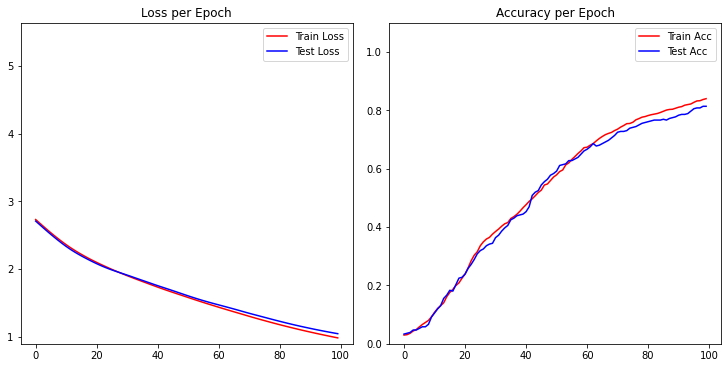

In [91]:
model = Net(64)
print_model(model)
results = demo(model, mnist, 100, verbose=True)
plot(results)

In [122]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)
n_train = 1437
n_test = 360


X_train = train_data.data[:n_train].to(dtype=torch.float)
X_train = X_train.reshape(n_train, 1, 28, 28)
y_train = train_data.targets[:n_train].to(dtype=torch.long)

X_test = test_data.data[:n_test].to(dtype=torch.float)
X_test = X_test.reshape(n_test, 1, 28, 28)
y_test = test_data.targets[:n_test].to(dtype=torch.long)

large_mnist = (X_train, X_test, y_train, y_test)
print("train:", large_mnist[0].shape)
print("test: ", large_mnist[1].shape)

train: torch.Size([1437, 1, 28, 28])
test:  torch.Size([360, 1, 28, 28])


In total, this network has  7994  parameters
  10 Train loss: 2.697 Train accuracy: 46.2% Test loss: 2.743 Test accuracy: 41.7%
  20 Train loss: 1.239 Train accuracy: 67.1% Test loss: 1.380 Test accuracy: 63.1%
  30 Train loss: 0.736 Train accuracy: 78.1% Test loss: 0.905 Test accuracy: 72.8%
  40 Train loss: 0.510 Train accuracy: 84.2% Test loss: 0.755 Test accuracy: 77.2%
  50 Train loss: 0.367 Train accuracy: 88.8% Test loss: 0.634 Test accuracy: 80.3%
  60 Train loss: 0.278 Train accuracy: 91.8% Test loss: 0.564 Test accuracy: 83.3%
  70 Train loss: 0.217 Train accuracy: 93.5% Test loss: 0.524 Test accuracy: 84.2%
  80 Train loss: 0.172 Train accuracy: 94.7% Test loss: 0.502 Test accuracy: 85.6%
  90 Train loss: 0.137 Train accuracy: 96.3% Test loss: 0.495 Test accuracy: 84.7%
 100 Train loss: 0.109 Train accuracy: 97.2% Test loss: 0.483 Test accuracy: 84.4%


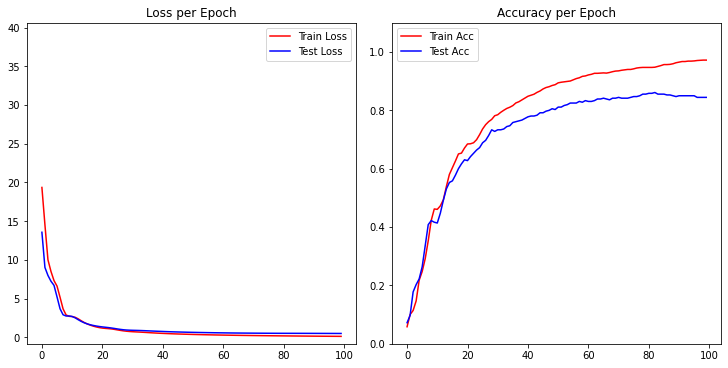

In [119]:
model = CNN(linear_layer_size=576)
print_model(model)
results = demo(model, large_mnist, 100, verbose=True)
plot(results)

In total, this network has  25818  parameters
  10 Train loss: 1.961 Train accuracy: 32.2% Test loss: 2.032 Test accuracy: 31.1%
  20 Train loss: 1.655 Train accuracy: 51.7% Test loss: 1.813 Test accuracy: 42.8%
  30 Train loss: 1.463 Train accuracy: 60.8% Test loss: 1.609 Test accuracy: 51.7%
  40 Train loss: 1.306 Train accuracy: 67.7% Test loss: 1.507 Test accuracy: 56.4%
  50 Train loss: 1.178 Train accuracy: 73.5% Test loss: 1.397 Test accuracy: 59.7%
  60 Train loss: 1.070 Train accuracy: 77.2% Test loss: 1.312 Test accuracy: 62.5%
  70 Train loss: 0.978 Train accuracy: 79.7% Test loss: 1.245 Test accuracy: 63.3%
  80 Train loss: 0.900 Train accuracy: 81.8% Test loss: 1.187 Test accuracy: 65.6%
  90 Train loss: 0.836 Train accuracy: 83.4% Test loss: 1.135 Test accuracy: 66.9%
 100 Train loss: 0.778 Train accuracy: 84.1% Test loss: 1.085 Test accuracy: 67.8%


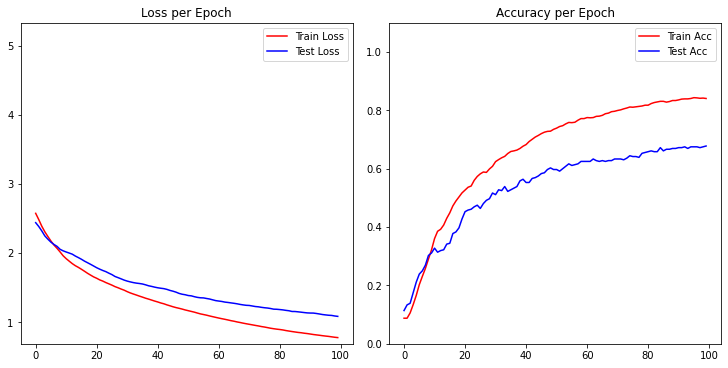

In [121]:
model = Net(784)
print_model(model)
results = demo(model, large_mnist, 100, verbose=True)
plot(results)